# Creating Reactions
Once we have the species in hand, we can then specify the reactions between these different species. Consider a simple reaction where ionized hydrogen atom recombines with an electron and gives a neural Hydrogen atom:

$$
    \begin{align*}
    \rm H^+ + e^- &\rightarrow \rm H \quad &(k01)  \\
    \rm H + e^- &\rightarrow \rm H^+ + 2 e^- \quad &(k02)
    \end{align*}
$$

## Initialize Chemical Species

In [14]:
from dengo.reaction_classes import AtomicSpecies, MolecularSpecies
from dengo.chemical_network import species_registry

HI = AtomicSpecies('H', free_electrons=0.0)
HII = AtomicSpecies("H", free_electrons=1.0)
H2I = MolecularSpecies("H2", weight=2.01588, free_electrons=0.0)
de  = species_registry['de']

## Register new reactions with the `reaction` decorator
a `reaction` to `dengo` is primarily composed of:
- **name** of the reaction, i.e. `k01`, `k02`
- **LHS** of the reaction /input species 
- **RHS** of the reaction / output species
- **reaction rate**, that often times dependent on the temperature of the gas parcel.

### Reactants and Products
The LHS (reactants) and RHS (Products) are composed of a list of tuples of the consituents of the equation.
For a fiducial reaction:
$$
a A + b B → p P + q Q
$$
`Dengo` expects an input of LHS and RHS to be `[ (a, A), (b, B)]`, `[(p, P), (q, Q)]`.
The first and argument in each tuple are the stoichiometric number and the registered `ChemicalSpecies` 

For example, `dengo` expects the `LHS` and `RHS` to have an input of the type for `k02`:
```python
LHS = [(1, HI), (1, de)]
RHS = [(1, HII), (2, de)]
```

### Reaction Rate
Reaction are oftentimes dependent on temperature.
`dengo` expects a reaction rate function that take `state` as input. `state` contains not only temperature in $\rm K$, but also in Kelvin log scale, and in $\rm eV/K$ (electron volts per kelvin), and  $\rm eV/K$ in log scale. In practice, `ChemicalNetwork` which we will cover in the chapter to come contains these attributes and are treated as `state` input.

```python
class state:
    def __init__(self, T_bounds=(1, 1e8), n_bins=1024):
        """Initialize the range of temperature over which the rate tables are generated

        Parameters
        ----------
        T_bounds: List[Float, Float], optional (default=(1,1e8))
            the range over which the rates table is interpolated

        n_bins: int, optional (default=1024)

        """
        self.n_bins = n_bins
        self.T = np.logspace(
            np.log(T_bounds[0]), np.log(T_bounds[1]), n_bins, base=np.e
        )
        self.logT = np.log(self.T)
        self.tev = self.T / tevk
        self.logtev = np.log(self.tev)
        self.T_bounds = T_bounds
```

In [18]:
from dengo.reaction_classes import reaction
from dengo.chemical_network import reaction_registry

tiny = 1e-60
# -- k01 --
@reaction('k01', [   (1,HI),   (1,de)], [  (1,HII),   (2,de)])
def rxn(state):
    vals = np.exp(-32.71396786375
              + 13.53655609057*state.logtev
              - 5.739328757388*state.logtev**2
              + 1.563154982022*state.logtev**3
              - 0.2877056004391*state.logtev**4
              + 0.03482559773736999*state.logtev**5
              - 0.00263197617559*state.logtev**6
              + 0.0001119543953861*state.logtev**7
              - 2.039149852002e-6*state.logtev**8)
    # taken from Abel 1999
    vals = np.maximum(vals , tiny *np.ones((len(state.T))) )
    return vals

@reaction('k02', [  (1,HII),   (1,de)], [   (1,HI),         ])
def rxn(state):
    _i1 = (state.T > 5500)
    _i2 = ~_i1
    vals = np.exp(-28.61303380689232
                  - 0.7241125657826851*state.logtev
                  - 0.02026044731984691*state.logtev**2
                  - 0.002380861877349834*state.logtev**3
                  - 0.0003212605213188796*state.logtev**4
                  - 0.00001421502914054107*state.logtev**5
                  + 4.989108920299513e-6*state.logtev**6
                  + 5.755614137575758e-7*state.logtev**7
                  - 1.856767039775261e-8*state.logtev**8
                  - 3.071135243196595e-9*state.logtev**9)
    vals[_i2] = 3.92e-13 / state.tev[_i2]**0.6353

    return vals

Similar to species, the reaction is registered in the `dengo.chemical_network.reaction_registry`, and the `dengo.reaction_classes.Reaction` is accesible through the reaction registry.

In [19]:
reaction_registry['k01'], type(reaction_registry['k01'])

(k01 : 1*H_1 + 1*de => 1*H_2 + 2*de, dengo.reaction_classes.Reaction)

In [20]:
reaction_registry['k02'], type(reaction_registry['k02'])

(k02 : 1*H_2 + 1*de => 1*H_1, dengo.reaction_classes.Reaction)

## Visualize the rate as a function of temperature

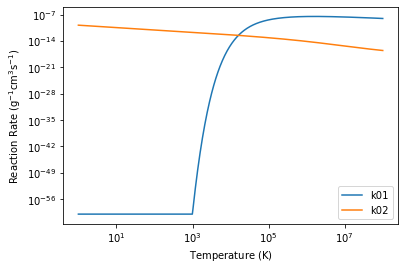

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from dengo.chemistry_constants import tevk

class state:
    def __init__(self, T_bounds=(1, 1e8), n_bins=1024):
        """Initialize the range of temperature over which the rate tables are generated

        Parameters
        ----------
        T_bounds: List[Float, Float], optional (default=(1,1e8))
            the range over which the rates table is interpolated

        n_bins: int, optional (default=1024)

        """
        self.n_bins = n_bins
        self.T = np.logspace(
            np.log(T_bounds[0]), np.log(T_bounds[1]), n_bins, base=np.e
        )
        self.logT = np.log(self.T)
        self.tev = self.T / tevk
        self.logtev = np.log(self.tev)
        self.T_bounds = T_bounds
        
        
temperature_state = state()



rxnk01 = reaction_registry['k01']
rxnk02 = reaction_registry['k02']
temperature = temperature_state.T
rxnk01_rate = rxnk01.coeff_fn(temperature_state)
rxnk02_rate = rxnk02.coeff_fn(temperature_state)

plt.loglog(temperature, rxnk01_rate, label='k01')
plt.loglog(temperature, rxnk02_rate, label='k02')
plt.xlabel(r'Temperature $(\rm K)$')
plt.ylabel(r'Reaction Rate $(\rm g^{-1} cm^{3} s^{-1} )$')
plt.legend()
plt.legend()